In [1]:
import pandas as pd
import numpy as np

import os

import cv2
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
test_df = pd.read_csv('test.csv')

In [3]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

def process(data, image_path):
    data['Id'] = data['id'].astype(str) + '.jpg'
    
    data['image_paths'] = data['Id'].apply(lambda x: os.path.join(image_path, x))
    data = data[['image_paths'] + [col for col in data.columns if col != 'image_paths']]
    
    img = cv2.imread(data['image_paths'][0])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB
    plt.axis('off')  
    plt.show()
    return data

def preprocess(data):
    x=[]
    for img in data['image_paths']:
        img = cv2.imread(img)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #since our images are already black and white.
        img = cv2.resize(img, (164, 164))
        img=img/255.0    
        x.append(img)
    image_array =np.array(x)
    return image_array

def features_extraction_test(data):
    features = data.drop(columns = ['image_paths','Id','id'])
    features_data = features.to_numpy() 
    return features_data

def features_extraction_train(data):
    features = data.drop(columns = ['image_paths','Id','id','species'])
    features_data = features.to_numpy() 
    return features_data

def target_extraction_train(data):
    target = data['species']
    y = label_encoder.fit_transform(target)
    target = pd.DataFrame(y) #sparse categorical crossentropy as the loss fucntion because our labels are integers.
    
    target.columns = ['label']
    print(f'Class amount to set the last layer of the model is: {target.label.nunique()}') #amount of classes
    return target

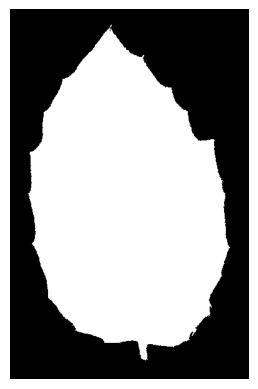

In [4]:
test_df = process(test_df,'images/')

In [5]:
test_images = preprocess(test_df)

In [6]:
features_test = features_extraction_test(test_df)

In [7]:
df = pd.read_csv('train.csv')

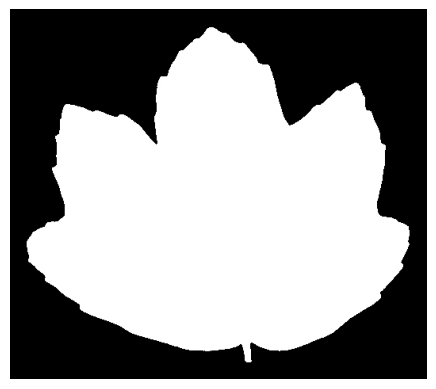

In [8]:
df = process(df,'images/')

In [9]:
train_images = preprocess(df)

In [10]:
features_train = features_extraction_train(df)

In [11]:
target_train = target_extraction_train(df)

Class amount to set the last layer of the model is: 99


In [12]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate
from tensorflow.keras.models import Model

image_height, image_width, channel = 164, 164, 3

# CNN Part for Image Feature Extraction (CONVOLUTIONAL NEURAL NETWORK PART)
image_input = Input(shape=(image_height, image_width, channel))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)  # Latent Space (Bottleneck)

# Numerical Data Part for CSV Features (DEEP NEURAL NETWORK PART)
csv_input = Input(shape=(192,))  # features.shape
y = Dense(128, activation='relu')(csv_input)
#y = Dense(64, activation='relu')(y)
y = Dense(32, activation='relu')(y)

# Concatenate Latent Space from CNN with CSV Numerical Features
combined = Concatenate()([x, y])

# Final Fully Connected Layers for Classification
z = Dense(128, activation='relu')(combined)
z = Dense(99, activation='softmax')(z)

# Define and Compile the Model
model = Model(inputs=[image_input, csv_input], outputs=z)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "best_model.keras"  # File path to save the model
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
#    save_weights_only=True,  # Save only the weights
    monitor='loss',          # Monitor training loss
    save_best_only=True,     # Save only the best model
    mode='min',              # Save the model when the monitored quantity is minimized
    verbose=1               # Print messages when saving the model
)

#model.load_weights(checkpoint_path)
#mode: Defines whether to minimize or maximize the monitored metric. Use 'min' for loss and 'max' for accuracy.

In [14]:
history = model.fit([train_images, features_train], target_train, epochs=30, batch_size=16, callbacks=[model_checkpoint_callback]) 

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.0386 - loss: 4.5296
Epoch 1: loss improved from inf to 4.27215, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.0393 - loss: 4.5256
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4675 - loss: 2.2579
Epoch 2: loss improved from 4.27215 to 2.04201, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.4680 - loss: 2.2545
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7565 - loss: 0.9076
Epoch 3: loss improved from 2.04201 to 0.92981, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.7563 - loss: 0.9080
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8715 - loss: 0.4477
Epoch 4: loss improved from 0.92981 to 0.51720, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.8711 - loss: 0.4488
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━

In [36]:
print('Loss is: 1.8478e-05 which is 0.0000184')

Loss is: 1.8478e-05 which is 0.0000184


In [17]:
#model.save('my_model_2.keras')

In [18]:
#from tensorflow.keras.models import load_model
#loaded_model = load_model('my_model_2.keras')

In [30]:
#predictions = loaded_model.predict([test_images, features_test])

In [21]:
from tensorflow.keras.models import load_model
my_model = load_model(checkpoint_path)

In [22]:
predictions = my_model.predict([test_images, features_test])
#predictions = np.clip(predictions, 1e-15, 1 - 1e-15)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


In [23]:
predictions.shape #(num_test_images, num_classes)

(594, 99)

### Prepare Candidate Species Names
    We used label encoder to encode the target categories with number, we can reverse that encoding to get the species names back:

In [24]:
#test_df.head()

## Forming Submission Data Frame,
    -> image_ids: Extracted from your test dataset, representing the unique identifier for each image (e.g., file name).
    -> species_names: Using the LabelEncoder to get the names of all species from the integer class indices. We inverse transformed the names of our ids back to the categorical (string) value.
        For each image:
        We fetch the image ID.
        We append the predicted probabilities for all species to the row.
    -> submission_df: A Pandas DataFrame containing all image IDs, species names, and their associated probabilities.

In [25]:
# Extract image IDs from your test dataframe
image_ids = test_df['id'].values 

# Get species names back in original order using LabelEncoder
species_names = label_encoder.inverse_transform(np.arange(99))


submission_data = []

# Loop through each image's predictions
for i, img_id in enumerate(image_ids):
    # Get the probabilities for the current image
    img_probs = predictions[i]
    
    # Prepare a dictionary for each row, with image ID and probabilities for each species
    row = {
        'id': img_id
    }
    
    # Add all species probabilities to the row (species_names[j]: img_probs[j] for each j)
    for j, species_name in enumerate(species_names):
        row[species_name] = img_probs[j]
    
    # Append the row to the submission data list
    submission_data.append(row)

# Convert the submission data into a DataFrame
submission_df = pd.DataFrame(submission_data)


In [26]:
submission_df.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,Alnus_Cordata,Alnus_Maximowiczii,Alnus_Rubra,Alnus_Sieboldiana,Alnus_Viridis,Arundinaria_Simonii,Betula_Austrosinensis,Betula_Pendula,Callicarpa_Bodinieri,Castanea_Sativa,Celtis_Koraiensis,Cercis_Siliquastrum,Cornus_Chinensis,Cornus_Controversa,Cornus_Macrophylla,Cotinus_Coggygria,Crataegus_Monogyna,Cytisus_Battandieri,Eucalyptus_Glaucescens,Eucalyptus_Neglecta,Eucalyptus_Urnigera,Fagus_Sylvatica,Ginkgo_Biloba,Ilex_Aquifolium,Ilex_Cornuta,Liquidambar_Styraciflua,Liriodendron_Tulipifera,Lithocarpus_Cleistocarpus,Lithocarpus_Edulis,Magnolia_Heptapeta,Magnolia_Salicifolia,Morus_Nigra,Olea_Europaea,Phildelphus,Populus_Adenopoda,Populus_Grandidentata,Populus_Nigra,Prunus_Avium,Prunus_X_Shmittii,Pterocarya_Stenoptera,Quercus_Afares,Quercus_Agrifolia,Quercus_Alnifolia,Quercus_Brantii,Quercus_Canariensis,Quercus_Castaneifolia,Quercus_Cerris,Quercus_Chrysolepis,Quercus_Coccifera,Quercus_Coccinea,Quercus_Crassifolia,Quercus_Crassipes,Quercus_Dolicholepis,Quercus_Ellipsoidalis,Quercus_Greggii,Quercus_Hartwissiana,Quercus_Ilex,Quercus_Imbricaria,Quercus_Infectoria_sub,Quercus_Kewensis,Quercus_Nigra,Quercus_Palustris,Quercus_Phellos,Quercus_Phillyraeoides,Quercus_Pontica,Quercus_Pubescens,Quercus_Pyrenaica,Quercus_Rhysophylla,Quercus_Rubra,Quercus_Semecarpifolia,Quercus_Shumardii,Quercus_Suber,Quercus_Texana,Quercus_Trojana,Quercus_Variabilis,Quercus_Vulcanica,Quercus_x_Hispanica,Quercus_x_Turneri,Rhododendron_x_Russellianum,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,3.433710e-28,5.348304e-13,3.802581e-22,3.766198e-09,7.841725e-20,1.972096e-24,2.519512e-10,2.995295e-17,9.449199e-14,9.545757e-24,1.446215e-11,1.345696e-14,6.928236e-05,3.902623e-10,4.263632e-10,2.873922e-22,6.923991e-21,3.188633e-17,1.838720e-19,4.546823e-15,5.138020e-10,2.224214e-12,1.648400e-12,5.458237e-12,4.731546e-12,2.300760e-20,2.594491e-14,7.926698e-25,2.528388e-14,4.327656e-12,7.784860e-08,4.411598e-12,2.487609e-21,1.704446e-13,1.366943e-14,9.598316e-21,7.031631e-14,3.743098e-15,2.874251e-14,1.068119e-10,1.497017e-11,1.433333e-14,8.025088e-19,1.113416e-12,4.200617e-16,5.081436e-13,4.907300e-09,2.151744e-16,1.083121e-15,4.163583e-19,4.123047e-13,9.999292e-01,1.847158e-13,2.104721e-18,3.689728e-12,4.427556e-08,1.136874e-23,3.840560e-13,2.876383e-19,3.065236e-19,1.551174e-11,6.251554e-23,1.901495e-09,1.535753e-16,2.549256e-20,2.148923e-15,2.114178e-16,4.105826e-11,1.161372e-16,2.117022e-20,3.544629e-20,8.732912e-26,6.023570e-20,3.975696e-10,3.350069e-10,3.302499e-14,6.316333e-20,2.001632e-13,3.653787e-20,2.000614e-12,5.466054e-22,1.730838e-21,4.984848e-19,2.032964e-09,1.328515e-10,3.371001e-19,1.789066e-15,6.142146e-18,4.422333e-11,1.977944e-23,5.756488e-19,1.269239e-06,8.044370e-18,1.523968e-27,1.961106e-17,4.147305e-18,1.253841e-07,2.656247e-17,1.259025e-14
1,7,2.101121e-18,2.999653e-05,2.260660e-13,9.393696e-15,1.082307e-07,4.048475e-13,3.776730e-11,5.494072e-11,7.775746e-07,2.167897e-10,4.649155e-29,4.717466e-12,1.897718e-12,1.181749e-06,1.429702e-09,2.058715e-13,4.837263e-17,2.123475e-09,4.438052e-20,3.423989e-13,2.780689e-18,2.516936e-21,7.192192e-20,4.171189e-18,2.040311e-17,2.191392e-23,2.845403e-06,3.936515e-22,4.128089e-12,2.614326e-09,8.065736e-18,3.142903e-14,2.261790e-13,6.499529e-15,3.964740e-15,2.275821e-15,4.691489e-27,3.266558e-24,1.561642e-17,1.450390e-16,1.573559e-14,1.415293e-04,1.445672e-09,5.077071e-10,5.038260e-22,5.086345e-04,2.088542e-08,1.752454e-04,4.474560e-08,8.526380e-07,1.726288e-08,1.497443e-13,3.909294e-11,5.301158e-01,2.001288e-01,2.468613e-12,4.396113e-05,1.511828e-11,1.996360e-14,2.457590e-13,4.944516e-11,2.432420e-14,2.329854e-14,1.599517e-02,9.718817e-19,7.356375e-13,7.282660e-10,1.073361e-17,1.447331e-08,3.083643e-06,3.329879e-10,8.605158e-15,1.588001e-11,1.6153

In [27]:
probabilities = submission_df.iloc[0, 1:]  # Exclude the image_id column

# Find the index of the maximum probability
predicted_index = probabilities.idxmax()

# Display the predicted class
print(f"Predicted class: {predicted_index}")

Predicted class: Quercus_Agrifolia


In [29]:
9.999292e-01

0.9999292

In [40]:
# Save to CSV
submission_df.to_csv('submission.csv', index=False)